In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

## Data setup

### Data import

Data loading - the 'clean' data has datetime index 

In [3]:
df_temp = pd.read_csv(r"C:\Users\macie\OneDrive\Pulpit\Fellowship\999_OTHER\DP_paper\Line_Test1.csv")
df_temp.index = df_temp.apply(lambda row: datetime(year=int(row.Year), month=int(row.Month), day=int(row.Day), hour=int(row.Hour), minute=int(row.Minute)), axis=1)
df_temp.rename(columns={'TEMP_LINE_SM1':'temp'}, inplace=True)
df_temp.ffill(inplace=True)
df_temp_resampled = df_temp.copy()

Data standardization - std. scaling. We pick only the temperature column

In [4]:
df_data = pd.DataFrame(df_temp_resampled.temp)

data_mean = df_data.mean()
data_std = df_data.std()
df_data = (df_data - data_mean) / data_std

Data splits - train/val/test

In [5]:
len_data = len(df_data)

df_train = df_data[:int(0.7*len_data)]
df_val = df_data[int(0.7*len_data):int(0.9*len_data)]
df_test = df_data[int(0.9*len_data):]

In [6]:
df_test

,temp
2019-01-03 19:15:00,-0.508727
2019-01-03 19:20:00,-0.451950
2019-01-03 19:25:00,-0.427617
2019-01-03 19:30:00,-0.439784
2019-01-03 19:35:00,-0.456006
...,...
2019-01-06 23:35:00,0.156378
2019-01-06 23:40:00,0.136100
2019-01-06 23:45:00,0.099600
2019-01-06 23:50:00,0.095545


### Time window genrator

Window generator -> to be fed into the model. Sets up the time windows for the model.

In [230]:
class TimeWindowGenerator():

    def __init__(self, input_width, output_width=1, output_offset=1, df_train = df_train, df_val=df_val, df_test=df_test, column_name = ['temp']):

        # define the raw datasets
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test

        # Window parameters
        self.input_width = input_width
        self.output_width = output_width
        self.offset = output_offset
        self.total_size = self.input_width + self.offset
        
        # Define the indices
        self.input_indices = np.arange(0, self.input_width)
        self.output_indices = np.arange(self.total_size - self.output_width, self.total_size)
        
    # model representation when called
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.output_indices}'])
    

    def slice(self, batches):
        # For training probably many batches, for test and deployment: one at a time
        if len(np.shape(batches)) == 3:
            inputs = batches[:, slice(0, self.input_width)]
            output = batches[:, slice(self.total_size - self.output_width, self.total_size)]

        else:
            inputs = batches[slice(0, self.input_width)]
            output = batches[slice(self.total_size - self.output_width, self.total_size)]

        # Set shape for the tf dataset - works only if a tf.Dataset object is fed  
        # e.g., a timeseries_dataset_from_array object
        inputs.set_shape([None, self.input_width, None])
        output.set_shape([None, self.output_width, None])

        return inputs, output
    
    def compile_dataset(self, data, opt_shuffle=True):
        # Convert to numpy float32 - for the keras object
        data_array = np.array(data, dtype='float32')
        
        keras_dataset = tf.keras.utils.timeseries_dataset_from_array(
            data = data_array,
            targets=None,
            sequence_length=self.total_size,
            sequence_stride=1,
            shuffle=opt_shuffle,
            batch_size=32
        )

        keras_dataset = keras_dataset.map(self.slice)

        return keras_dataset
    
    @property
    def train(self):
        return self.compile_dataset(self.df_train)

    @property
    def val(self):
        return self.compile_dataset(self.df_val)

    @property
    def test(self):
        return self.compile_dataset(self.df_test, opt_shuffle=False)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

Universal trainer

In [231]:
def tiny_trainer(model, model_name, window_generator, max_epochs):
  cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  # cb_checkpointing = tf.keras.callbacks.ModelCheckpoint(r'models/line_temp_model_{}_10_mins.hdf5'.format(model_name), monitor='val_loss', save_best_only=True, save_weights_only=True)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window_generator.train, epochs=max_epochs,
                      validation_data=window_generator.val,
                      callbacks=[cb_early_stopping])
  return history

## Model definitions

### Persistance model - for comparison

In [232]:
window_1 = TimeWindowGenerator(input_width=1, df_train=df_train, df_val=df_val, df_test=df_test, output_offset=3)
window_6 = TimeWindowGenerator(input_width=6, df_train=df_train, df_val=df_val, df_test=df_test, output_offset=3)

In [233]:
window_6

Total window size: 9
Input indices: [0 1 2 3 4 5]
Label indices: [8]

### Model definitions

In [234]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [235]:
mlp_model_05 = tf.keras.Sequential([
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1),
    # Reshape into output
    tf.keras.layers.Reshape([-1, 1])
])

In [236]:
mlp_model_10 = tf.keras.Sequential([
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    # Reshape into output
    tf.keras.layers.Reshape([-1, 1])
])

In [237]:
mlp_model_20 = tf.keras.Sequential([
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1),
    # Reshape into output
    tf.keras.layers.Reshape([-1, 1])
])

In [238]:
mlp_model_05b = tf.keras.Sequential([
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1),
    # Reshape into output
    tf.keras.layers.Reshape([-1, 1])
])

In [239]:
mlp_model_10b = tf.keras.Sequential([
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    # Reshape into output
    tf.keras.layers.Reshape([-1, 1])
])

In [240]:
mlp_model_20b = tf.keras.Sequential([
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1),
    # Reshape into output
    tf.keras.layers.Reshape([-1, 1])
])

### Train

In [241]:
persistance_model = Baseline(label_index=None)
history_persitance = tiny_trainer(model=persistance_model, model_name='persistence', window_generator=window_1, max_epochs=500)

Epoch 1/500


202/202 [==============================] - 1s 4ms/step - loss: 0.0527 - mean_absolute_error: 0.1349 - val_loss: 0.0388 - val_mean_absolute_error: 0.1325
Epoch 2/500
202/202 [==============================] - 1s 2ms/step - loss: 0.0527 - mean_absolute_error: 0.1349 - val_loss: 0.0388 - val_mean_absolute_error: 0.1325
Epoch 3/500
202/202 [==============================] - 0s 2ms/step - loss: 0.0527 - mean_absolute_error: 0.1349 - val_loss: 0.0388 - val_mean_absolute_error: 0.1325
Epoch 4/500
202/202 [==============================] - 0s 2ms/step - loss: 0.0527 - mean_absolute_error: 0.1349 - val_loss: 0.0388 - val_mean_absolute_error: 0.1325
Epoch 5/500
202/202 [==============================] - 0s 2ms/step - loss: 0.0527 - mean_absolute_error: 0.1349 - val_loss: 0.0388 - val_mean_absolute_error: 0.1325
Epoch 6/500
202/202 [==============================] - 0s 2ms/step - loss: 0.0527 - mean_absolute_error: 0.1349 - val_loss: 0.0388 - val_mean_absolute_error: 0.1325
Epoch 7/500
202/202 [=

In [242]:
history_mlp = tiny_trainer(model=mlp_model_05, model_name='mlp_05', window_generator=window_6, max_epochs=500)

Epoch 1/500
202/202 [==============================] - 1s 2ms/step - loss: 0.8595 - mean_absolute_error: 0.6581 - val_loss: 1.2185 - val_mean_absolute_error: 0.8013
Epoch 2/500
202/202 [==============================] - 1s 2ms/step - loss: 0.6368 - mean_absolute_error: 0.5606 - val_loss: 0.9112 - val_mean_absolute_error: 0.6822
Epoch 3/500
202/202 [==============================] - 0s 2ms/step - loss: 0.4733 - mean_absolute_error: 0.4697 - val_loss: 0.6168 - val_mean_absolute_error: 0.5497
Epoch 4/500
202/202 [==============================] - 0s 2ms/step - loss: 0.2914 - mean_absolute_error: 0.3612 - val_loss: 0.3489 - val_mean_absolute_error: 0.4083
Epoch 5/500
202/202 [==============================] - 0s 2ms/step - loss: 0.1818 - mean_absolute_error: 0.2817 - val_loss: 0.2032 - val_mean_absolute_error: 0.3115
Epoch 6/500
202/202 [==============================] - 0s 2ms/step - loss: 0.1272 - mean_absolute_error: 0.2350 - val_loss: 0.1275 - val_mean_absolute_error: 0.2500
Epoch 7/50

In [243]:
history_mlp = tiny_trainer(model=mlp_model_10, model_name='mlp_10', window_generator=window_6, max_epochs=500)

Epoch 1/500
202/202 [==============================] - 1s 4ms/step - loss: 0.4908 - mean_absolute_error: 0.5600 - val_loss: 0.3518 - val_mean_absolute_error: 0.4766
Epoch 2/500
202/202 [==============================] - 1s 3ms/step - loss: 0.3370 - mean_absolute_error: 0.4497 - val_loss: 0.2372 - val_mean_absolute_error: 0.3791
Epoch 3/500
202/202 [==============================] - 1s 4ms/step - loss: 0.2414 - mean_absolute_error: 0.3767 - val_loss: 0.1607 - val_mean_absolute_error: 0.3098
Epoch 4/500
202/202 [==============================] - 1s 3ms/step - loss: 0.1678 - mean_absolute_error: 0.3100 - val_loss: 0.1079 - val_mean_absolute_error: 0.2503
Epoch 5/500
202/202 [==============================] - 1s 2ms/step - loss: 0.1205 - mean_absolute_error: 0.2544 - val_loss: 0.0796 - val_mean_absolute_error: 0.2080
Epoch 6/500
202/202 [==============================] - 1s 3ms/step - loss: 0.0987 - mean_absolute_error: 0.2196 - val_loss: 0.0686 - val_mean_absolute_error: 0.1863
Epoch 7/50

In [244]:
history_mlp = tiny_trainer(model=mlp_model_20, model_name='mlp_20', window_generator=window_6, max_epochs=500)

Epoch 1/500
202/202 [==============================] - 1s 3ms/step - loss: 1.3353 - mean_absolute_error: 0.7430 - val_loss: 1.3357 - val_mean_absolute_error: 0.7596
Epoch 2/500
202/202 [==============================] - 0s 2ms/step - loss: 0.4663 - mean_absolute_error: 0.4137 - val_loss: 0.3996 - val_mean_absolute_error: 0.4213
Epoch 3/500
202/202 [==============================] - 1s 3ms/step - loss: 0.1618 - mean_absolute_error: 0.2557 - val_loss: 0.1243 - val_mean_absolute_error: 0.2483
Epoch 4/500
202/202 [==============================] - 1s 3ms/step - loss: 0.0928 - mean_absolute_error: 0.1989 - val_loss: 0.0725 - val_mean_absolute_error: 0.1939
Epoch 5/500
202/202 [==============================] - 1s 3ms/step - loss: 0.0810 - mean_absolute_error: 0.1838 - val_loss: 0.0617 - val_mean_absolute_error: 0.1785
Epoch 6/500
202/202 [==============================] - 1s 2ms/step - loss: 0.0763 - mean_absolute_error: 0.1759 - val_loss: 0.0573 - val_mean_absolute_error: 0.1708
Epoch 7/50

In [245]:
history_mlp = tiny_trainer(model=mlp_model_05b, model_name='mlp_05b', window_generator=window_6, max_epochs=500)

Epoch 1/500
202/202 [==============================] - 1s 4ms/step - loss: 0.1590 - mean_absolute_error: 0.2778 - val_loss: 0.1329 - val_mean_absolute_error: 0.2540
Epoch 2/500
202/202 [==============================] - 1s 3ms/step - loss: 0.1105 - mean_absolute_error: 0.2156 - val_loss: 0.0847 - val_mean_absolute_error: 0.2022
Epoch 3/500
202/202 [==============================] - 1s 2ms/step - loss: 0.0971 - mean_absolute_error: 0.1961 - val_loss: 0.0720 - val_mean_absolute_error: 0.1867
Epoch 4/500
202/202 [==============================] - 0s 2ms/step - loss: 0.0921 - mean_absolute_error: 0.1896 - val_loss: 0.0677 - val_mean_absolute_error: 0.1813
Epoch 5/500
202/202 [==============================] - 1s 3ms/step - loss: 0.0883 - mean_absolute_error: 0.1854 - val_loss: 0.0644 - val_mean_absolute_error: 0.1770
Epoch 6/500
202/202 [==============================] - 1s 2ms/step - loss: 0.0849 - mean_absolute_error: 0.1819 - val_loss: 0.0620 - val_mean_absolute_error: 0.1738
Epoch 7/50

In [246]:
history_mlp = tiny_trainer(model=mlp_model_10b, model_name='mlp_10b', window_generator=window_6, max_epochs=500)

Epoch 1/500
202/202 [==============================] - 3s 3ms/step - loss: 0.9604 - mean_absolute_error: 0.7825 - val_loss: 1.2828 - val_mean_absolute_error: 0.9182
Epoch 2/500
202/202 [==============================] - 1s 3ms/step - loss: 0.8291 - mean_absolute_error: 0.7245 - val_loss: 1.0530 - val_mean_absolute_error: 0.8176
Epoch 3/500
202/202 [==============================] - 1s 3ms/step - loss: 0.5745 - mean_absolute_error: 0.5812 - val_loss: 0.5992 - val_mean_absolute_error: 0.5903
Epoch 4/500
202/202 [==============================] - 1s 3ms/step - loss: 0.2825 - mean_absolute_error: 0.3915 - val_loss: 0.2579 - val_mean_absolute_error: 0.3691
Epoch 5/500
202/202 [==============================] - 1s 3ms/step - loss: 0.1378 - mean_absolute_error: 0.2562 - val_loss: 0.1149 - val_mean_absolute_error: 0.2364
Epoch 6/500
202/202 [==============================] - 1s 3ms/step - loss: 0.0960 - mean_absolute_error: 0.2005 - val_loss: 0.0780 - val_mean_absolute_error: 0.1935
Epoch 7/50

In [247]:
history_mlp = tiny_trainer(model=mlp_model_20b, model_name='mlp_20b', window_generator=window_6, max_epochs=500)

Epoch 1/500
202/202 [==============================] - 1s 3ms/step - loss: 0.6907 - mean_absolute_error: 0.6476 - val_loss: 0.2728 - val_mean_absolute_error: 0.4026
Epoch 2/500
202/202 [==============================] - 1s 3ms/step - loss: 0.1176 - mean_absolute_error: 0.2354 - val_loss: 0.0663 - val_mean_absolute_error: 0.1725
Epoch 3/500
202/202 [==============================] - 1s 2ms/step - loss: 0.0813 - mean_absolute_error: 0.1749 - val_loss: 0.0606 - val_mean_absolute_error: 0.1645
Epoch 4/500
202/202 [==============================] - 1s 3ms/step - loss: 0.0781 - mean_absolute_error: 0.1695 - val_loss: 0.0577 - val_mean_absolute_error: 0.1599
Epoch 5/500
202/202 [==============================] - 1s 3ms/step - loss: 0.0749 - mean_absolute_error: 0.1650 - val_loss: 0.0551 - val_mean_absolute_error: 0.1561
Epoch 6/500
202/202 [==============================] - 1s 3ms/step - loss: 0.0725 - mean_absolute_error: 0.1617 - val_loss: 0.0530 - val_mean_absolute_error: 0.1531
Epoch 7/50

### Test

In [248]:
trained_models = {
    'mlp_05': mlp_model_05,
    'mlp_10': mlp_model_10,
    'mlp_20': mlp_model_20,
    'mlp_05b': mlp_model_05b,
    'mlp_10b': mlp_model_10b,
    'mlp_20b': mlp_model_20b,
}

for n in trained_models:
    trained_models[n].save(r'models/line_temp_model_{}_15_mins.hdf5'.format(n))

In [249]:
model_error_val = {}
model_error_test = {}
model_FS_test = {}

print('Test model: persistence')
model_error_val['persistance'] = persistance_model.evaluate(window_1.val, verbose=1)
model_error_test['persistance'] = persistance_model.evaluate(window_1.test, verbose=1)



for name, model in trained_models.items():
    print(f'Test model: {name}')
    model_error_val[name] = model.evaluate(window_6.val, verbose=1)
    model_error_test[name] = model.evaluate(window_6.test, verbose=1)
    trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    model_FS_test[name] = 1- (model_error_test[name][1] / model_error_test["persistance"][1])

    print(f'Number of parameters: {trainable_params}')
    print(f'FS_test = {1- (model_error_test[name][1] / model_error_test["persistance"][1]):.3}, FS_val = {1- (model_error_val[name][1] / model_error_val["persistance"][1]):.3}')

Test model: persistence
29/29 [==============================] - 0s 1ms/step - loss: 0.0465 - mean_absolute_error: 0.1445
Test model: mlp_05
29/29 [==============================] - 0s 1ms/step - loss: 0.0495 - mean_absolute_error: 0.1507
Number of parameters: 71
FS_test = -0.0429, FS_val = 0.0179
Test model: mlp_10
29/29 [==============================] - 0s 2ms/step - loss: 0.0475 - mean_absolute_error: 0.1477
Number of parameters: 191
FS_test = -0.0224, FS_val = 0.0184
Test model: mlp_20
29/29 [==============================] - 0s 2ms/step - loss: 0.0464 - mean_absolute_error: 0.1460
Number of parameters: 581
FS_test = -0.0106, FS_val = 0.0255
Test model: mlp_05b
29/29 [==============================] - 0s 2ms/step - loss: 0.0450 - mean_absolute_error: 0.1430
Number of parameters: 101
FS_test = 0.00982, FS_val = 0.0567
Test model: mlp_10b
29/29 [==============================] - 0s 3ms/step - loss: 0.0471 - mean_absolute_error: 0.1450
Number of parameters: 301
FS_test = -0.00381, FS

In [250]:
for key in model_error_test:
    print(key)
    print(f'RMSE: {np.sqrt(model_error_test[key][0]):.03f}')
    print(f'MAE: {model_error_test[key][1]:.03f}')

persistance
RMSE: 0.216
MAE: 0.144
mlp_05
RMSE: 0.222
MAE: 0.151
mlp_10
RMSE: 0.218
MAE: 0.148
mlp_20
RMSE: 0.215
MAE: 0.146
mlp_05b
RMSE: 0.212
MAE: 0.143
mlp_10b
RMSE: 0.217
MAE: 0.145
mlp_20b
RMSE: 0.216
MAE: 0.149


In [254]:
heights_5 = [-0.30703689139926404, -0.01422131780964464, -0.0005217070157221837, -0.018031434759318454, 0.03503366470308544, 0.08436101788320138]
heights_10 = [-0.04333260114009341, 0.0188142712211391, -0.03838395983071763, -0.03985975506068984, 0.0479286104135771, 0.04025522073999588]
heights_15 = [-0.04293350995875023, -0.02236810575739101, -0.010567094878774164, 0.00982418708485433, -0.003811709080938863, -0.028289809135001454]

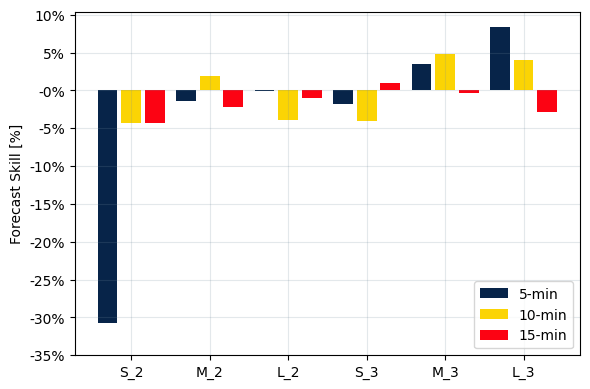

In [281]:
plt.figure(figsize=(6, 4))

plt.grid(visible=True, which='major', alpha=0.2, color='#748c9d')


x = np.arange(0, 6)
y = np.arange(-0.35, 0.15, 0.05)
plt.bar(x-0.3, heights_5, width=0.25, label='5-min', color='#072449')
plt.bar(x, heights_10, width=0.25, label='10-min', color='#fbd404')
plt.bar(x+0.3, heights_15, width=0.25, label='15-min', color='#fc0313')


plt.ylabel('Forecast Skill [%]')
plt.xticks(ticks=x, labels=['S_2', 'M_2', 'L_2', 'S_3', 'M_3', 'L_3'])
plt.yticks(ticks=y, labels=[f'{(item*100):.0f}%' for item in y])
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(r'img\DLR\results_mlps.png', dpi=300)
plt.show()

